--- Random Forest on Dataset1 Evaluation ---
Accuracy: 0.6238532110091743
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.75        77
           1       0.32      0.25      0.28        32

    accuracy                           0.62       109
   macro avg       0.52      0.51      0.51       109
weighted avg       0.60      0.62      0.61       109



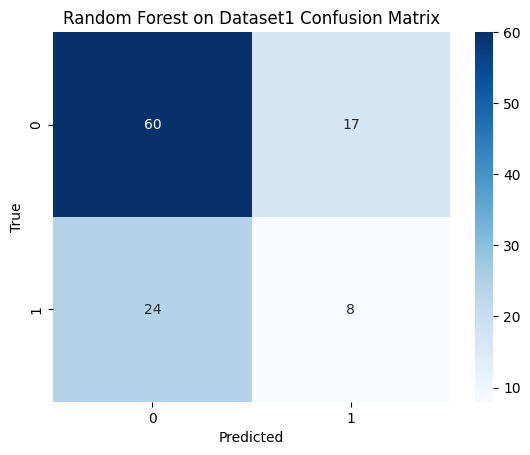

--- Logistic Regression on Dataset2 Evaluation ---
Accuracy: 0.8532110091743119
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90        77
           1       0.83      0.62      0.71        32

    accuracy                           0.85       109
   macro avg       0.85      0.79      0.81       109
weighted avg       0.85      0.85      0.85       109



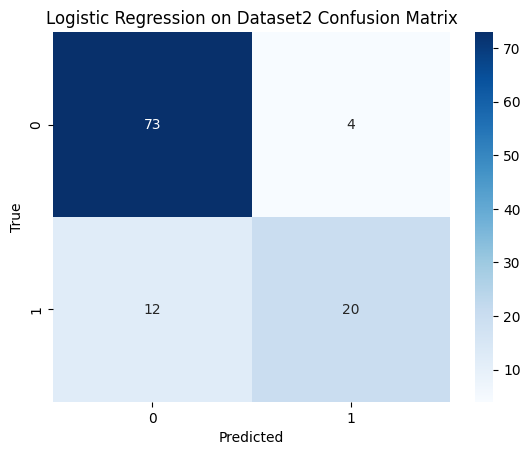

--- Ensemble Model Evaluation ---
Accuracy: 0.8623853211009175
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91        77
           1       0.87      0.62      0.73        32

    accuracy                           0.86       109
   macro avg       0.87      0.79      0.82       109
weighted avg       0.86      0.86      0.85       109



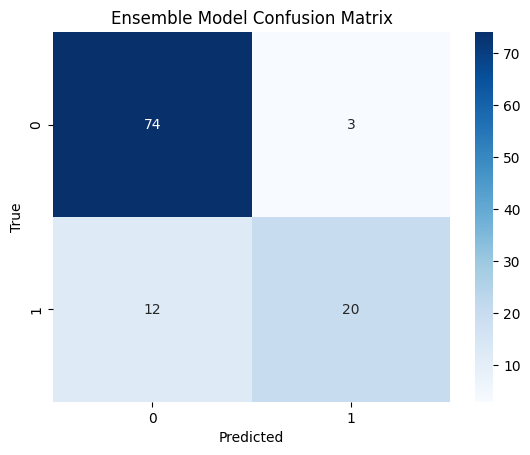

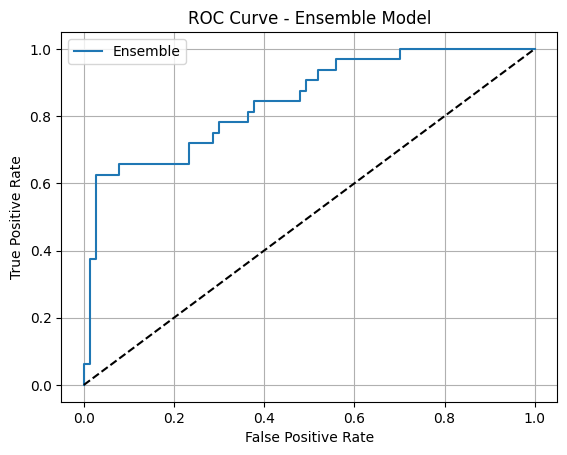

ROC-AUC Score (Ensemble): 0.8449675324675324


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    roc_auc_score, roc_curve
)

# -------------------------------
# 1. Load the datasets
# -------------------------------
dataset1 = pd.read_csv(r"C:\Users\HP\Downloads\PCOS Dataset\LRwithinfert 1.csv")
dataset2 = pd.read_csv(r"C:\Users\HP\Downloads\PCOS Dataset\LRwithout_inferti 2.csv")

# -------------------------------
# 2. Data Preprocessing Function
# -------------------------------
def preprocess_data(df):
    df = df.copy()

    # Drop irrelevant columns (like Sl. No, Patient File No., Unnamed columns)
    drop_cols = [col for col in df.columns if "Sl. No" in col or "Patient File" in col or "Unnamed" in col]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    # Ensure PCOS (Y/N) is integer
    if df['PCOS (Y/N)'].dtype != np.int64 and df['PCOS (Y/N)'].dtype != np.int32:
        df['PCOS (Y/N)'] = pd.to_numeric(df['PCOS (Y/N)'], errors="coerce")

    # Convert all object columns to numeric (coerce errors)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Drop columns with >10% missing
    df = df.dropna(axis=1, thresh=len(df) * 0.9)

    # Fill remaining NaN with median
    df = df.fillna(df.median(numeric_only=True))

    # Split features and labels
    X = df.drop('PCOS (Y/N)', axis=1)
    y = df['PCOS (Y/N)']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# Preprocess dataset1 and dataset2
X1, y1, scaler1 = preprocess_data(dataset1)
X2, y2, scaler2 = preprocess_data(dataset2)

# -------------------------------
# 3. Train Models Separately
# -------------------------------
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

model1 = RandomForestClassifier(random_state=42)
model2 = LogisticRegression(max_iter=1000, random_state=42)

model1.fit(X1_train, y1_train)
model2.fit(X2_train, y2_train)

y1_pred = model1.predict(X1_test)
y2_pred = model2.predict(X2_test)

# -------------------------------
# 4. Evaluate Each Model
# -------------------------------
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model(y1_test, y1_pred, "Random Forest on Dataset1")
evaluate_model(y2_test, y2_pred, "Logistic Regression on Dataset2")

# -------------------------------
# 5. Ensemble Model (probability averaging)
# -------------------------------
model1_proba = model1.predict_proba(X1_test)[:, 1]
model2_proba = model2.predict_proba(X2_test)[:, 1]

min_len = min(len(model1_proba), len(model2_proba))
ensemble_proba = (model1_proba[:min_len] + model2_proba[:min_len]) / 2
ensemble_pred = (ensemble_proba > 0.5).astype(int)
ensemble_true = y1_test[:min_len].reset_index(drop=True)

# -------------------------------
# 6. Evaluate Ensemble Model
# -------------------------------
evaluate_model(ensemble_true, ensemble_pred, "Ensemble Model")

fpr, tpr, _ = roc_curve(ensemble_true, ensemble_proba)
plt.plot(fpr, tpr, label="Ensemble")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Ensemble Model")
plt.legend()
plt.grid()
plt.show()

print("ROC-AUC Score (Ensemble):", roc_auc_score(ensemble_true, ensemble_proba))



In [2]:
# -------------------------------
# 7. Example Prediction (with input inspection)
# -------------------------------
def test_example(model, scaler, example_row, row_index=0):
    print(f"\n--- Example Prediction for Row {row_index} ---")
    
    # Show raw input row (as stored in dataset)
    print("\nRaw Input Row:")
    print(example_row)

    # Convert to numeric
    numeric_row = pd.to_numeric(example_row, errors="coerce")
    
    # Fill missing values with median of that row
    numeric_row = numeric_row.fillna(numeric_row.median(skipna=True))
    
    print("\nCleaned Numeric Input Row:")
    print(numeric_row)
    
    # Scale and predict
    example_scaled = scaler.transform([numeric_row.values])
    prediction = model.predict(example_scaled)
    
    result = "PCOS" if prediction[0] == 1 else "No PCOS"
    print("\nPredicted Result:", result)
    return result


# Use first row from dataset1 as test
sample_row = dataset1.drop(columns=["Sl. No", "Patient File No.", "PCOS (Y/N)"], errors="ignore").iloc[0]
test_example(model1, scaler1, sample_row, row_index=0)



--- Example Prediction for Row 0 ---

Raw Input Row:
  I   beta-HCG(mIU/mL)    1.99
II    beta-HCG(mIU/mL)    1.99
AMH(ng/mL)                2.07
Name: 0, dtype: object

Cleaned Numeric Input Row:
  I   beta-HCG(mIU/mL)    1.99
II    beta-HCG(mIU/mL)    1.99
AMH(ng/mL)                2.07
Name: 0, dtype: float64

Predicted Result: No PCOS


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'No PCOS'

In [3]:
# -------------------------------
# 7. User Input Prediction
# -------------------------------
def user_input_prediction(model, scaler, dataset):
    # Get feature columns (exclude IDs + target)
    feature_cols = [col for col in dataset.columns if col not in ["Sl. No", "Patient File No.", "PCOS (Y/N)"]]
    
    user_values = []
    print("\n--- Enter values for prediction ---")
    
    for col in feature_cols:
        val = input(f"Enter value for {col} (press Enter to use median): ")
        if val.strip() == "":  # if user skips
            median_val = pd.to_numeric(dataset[col], errors="coerce").median()
            user_values.append(median_val)
        else:
            try:
                user_values.append(float(val))
            except ValueError:
                # fallback to median if invalid
                median_val = pd.to_numeric(dataset[col], errors="coerce").median()
                user_values.append(median_val)
    
    # Scale input
    example_scaled = scaler.transform([user_values])
    prediction = model.predict(example_scaled)
    
    result = "PCOS" if prediction[0] == 1 else "No PCOS"
    print("\n--- Prediction Result ---")
    print("Input values:", user_values)
    print("Predicted Result:", result)
    return result


# Example: take input for Random Forest trained on dataset1
user_input_prediction(model1, scaler1, dataset1)



--- Enter values for prediction ---

--- Prediction Result ---
Input values: [3.8, 5.0, 3.0]
Predicted Result: No PCOS


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'No PCOS'